<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Homework 4: Practical - Convolutional Neural Networks <br>
<font color=696880 size=4>
    Arian Amani
    
    
____


# Problem
This assignment uses PyTorch to build and implement a residual CNN for solving a classification problem. Our goal is to classify handwritten digits from 0 to 9 on the MNIST dataset. You can try larger and more fun datasets if you have access to Google Colab. (for example: [facial emotion detection](https://www.kaggle.com/datasets/msambare/fer2013))

* It is highly recommended to run this notebook on Google Colab so that you can utilize its GPU.
* If you need to change the inputs of functions you are implementing, or want to add new cells or functions, feel free to do so.

# Setup

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
###########################################################
##  If you need any other packages, import them below    ##
###########################################################


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Prepare The Data (10 Points)

Write a composed transformation to transform our dataset's PIL images to tensors and normalize them with ```mean: 0.1307``` and ```std: 0.3081```: 

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html">torchvision.transforms.Compose</a>
</details>

In [4]:
###############################################################
##                Compose your transformations               ##
###############################################################
transformation = transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.ToTensor(), transforms.Normalize([0.1307], [0.3081])]) # Write your code here

Split the downloaded MNIST dataset into two dataloaders ```train``` & ```val```

In [5]:
# Download the MNIST dataset
mnist_data = datasets.MNIST(root='data/', download=True, transform=transformation)

# Number of images in the dataset: 60,000
print(len(mnist_data))

# Split the dataset into training and validation sets
train_data, valid_data = random_split(mnist_data, [50000, 10000]) 

60000


torch.Size([1, 28, 28])
9


(-0.5, 27.5, 27.5, -0.5)

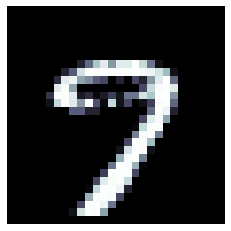

In [6]:
image, label = train_data[0]
print(image.shape)
print(label)
plt.imshow(image.permute(1, 2, 0).numpy(), cmap = plt.cm.bone)
plt.axis('off')

Create dataloaders for your train and validation data with ```batch size 16``` and ```shuffle = True``` for train loader.

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/tutorials/beginner/basics/data_tutorial.html">DATASETS & DATALOADERS</a>
</details>

In [7]:
###############################################################
##           Load the datasets into train/valid              ##
##                       dataloaders                         ##
###############################################################
train_loader = DataLoader(train_data, batch_size = 16, shuffle=True, num_workers = 1) # Write your code here
val_loader = DataLoader(valid_data, batch_size = 16, shuffle = False, num_workers = 1) # Write your code here

# Define Model (40 Points)

### You need to implement a model with the architecture below:
[Input: (BS, 1, 28, 28)] -- > [Conv2D (BS, 16, 28, 28)] --> ReLU --> [MaxPool2D (BS, 16, 14, 14): Residual1]

--> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Addition with Residual1]

--> [MaxPool2D (BS, 16, 7, 7)] --> [Conv2D (BS, 64, 7, 7)] --> [ReLU: Residual2]

--> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Addition with Residual2]

--> [GlobalAveragePooling (BS, 64, 1, 1)] --> [Flatten (BS, 64)] --> [Linear (BS, 10)] --> ReLU --> OUT

Here you can see the drawn schematic of the architecture, too: [Link](https://drive.google.com/file/d/1gQzafyxTkuvQr8T-xUncLmedX94LnY_l/view?usp=share_link)

<details>
<summary>Hint</summary>
<br>
These might be helpful:
<br>
<a href="https://pytorch.org/docs/stable/generated/torch.clone.html">TORCH.CLONE</a>
<br><br>
<a href="https://pytorch.org/docs/master/generated/torch.nn.AdaptiveAvgPool2d.html#torch.nn.AdaptiveAvgPool2d">AdaptiveAvgPool2d</a> with output size (1, 1) for global average pooling
<br><br>
<a href="https://arxiv.org/pdf/1512.03385.pdf">Deep Residual Learning for Image Recognition</a>
</details>

In [8]:
#####################################
##        Define your model        ##
##            Your Code            ##
#####################################

class ResidualBlock(nn.Module):
    def __init__(self, num_channel):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(num_channel, num_channel, 3, 1, 1)
        self.conv2 = nn.Conv2d(num_channel, num_channel, 3, 1, 1)

        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return x
    
class ResidualClassifier(nn.Module):
    def __init__(self):
        super(ResidualClassifier, self).__init__()
        
        
        self.conv1 = nn.Conv2d(1, 16, 3, 1, 1)
        self.maxpool1 = nn.MaxPool2d(2)
        
        self.res1 = ResidualBlock(16)
        
        self.maxpool2 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 64, 3, 1, 1)
        
        
        self.res2 = ResidualBlock(64)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.flat = nn.Flatten()
        
        self.linear = nn.Linear(64, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)
        
    
        identity = x.clone()
        x = self.res1(x)
        x = x + identity
        
        
        x = self.maxpool2(x)
        x = self.conv2(x)
        
        
        identity2 = x.clone()
        x = self.res2(x)
        
        x = x + identity2
        
        x = F.avg_pool2d(x, 4)
        x = self.flat(x)
        x = self.linear(x)
        
        
        return x

In [15]:
net = ResidualClassifier()
x = torch.randn(5, 1, 28, 28)
y = net(x)
y.shape

torch.Size([5, 10])

# Train Model (30 Points)

In [16]:
######################################################################
##        Instantiate model, define hyper parameters, optimizer,    ##
##        loss function and etc                                     ##
######################################################################
model = ResidualClassifier().to(device)
criterion = nn.CrossEntropyLoss() # Write your code here
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01) # Write your code here

In [17]:
######################################################################
##        Train your model (Complete the code below)                ##
######################################################################

#torch.autograd.set_detect_anomaly(True)
total_step = len(train_loader)
num_epochs = 10

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    correct = 0
    total = 0
    total_loss = 0
    
    model.train()
    with tqdm(enumerate(train_loader), total=total_step) as pbar:
        for i, (images, labels) in pbar:  
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            
            _, preds = output.max(dim=1)
            
            correct += (preds == labels).sum().item()
            total_loss += loss.item()
            total += labels.size(0)

            loss.backward()
            optimizer.step()
         
        acc = (correct/total) * 100.0
        tloss = total_loss/total_step
        
    
    train_losses.append(tloss)
    train_accuracies.append(acc)
    print('train epooch {}: acc={}, loss={}'.format(epoch, acc, tloss))
    
    
    correct = 0
    total = 0
    total_loss = 0
    
    model.eval()
    with torch.no_grad(), tqdm(enumerate(val_loader), total = len(val_loader)) as pbar:
        for i, (images, labels) in pbar:
            images, labels = images.to(device), labels.to(device)
            
            output = model(images)
            loss = criterion(output, labels)
            
            _, preds = output.max(dim=1)
            
            correct += (preds == labels).sum().item()
            total_loss += loss.item()
            total += labels.size(0)
            
    acc = (correct/total) * 100.0
    tloss = total_loss/len(val_loader)
        
    val_losses.append(tloss)
    val_accuracies.append(acc)
    print('validation epooch {}: acc={}, loss={}'.format(epoch, acc, tloss))
    

  0%|                                                  | 0/3125 [00:00<?, ?it/s]Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/connection.py", line 416, in _send_bytes
    self._send(header + buf)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
100%|██████████████████████████████████████| 3125/3125 [00:21<00:00, 142.27it/s]

train epooch 0: acc=88.004, loss=0.37718715171456335



100%|████████████████████████████████████████| 625/625 [00:02<00:00, 309.56it/s]

validation epooch 0: acc=92.86, loss=0.254561132478714



100%|██████████████████████████████████████| 3125/3125 [00:21<00:00, 143.01it/s]

train epooch 1: acc=93.822, loss=0.210003497468438



100%|████████████████████████████████████████| 625/625 [00:02<00:00, 311.36it/s]

validation epooch 1: acc=94.16, loss=0.21675362251056357



100%|██████████████████████████████████████| 3125/3125 [00:22<00:00, 139.47it/s]

train epooch 2: acc=94.05799999999999, loss=0.20896881668594666



100%|████████████████████████████████████████| 625/625 [00:02<00:00, 250.54it/s]

validation epooch 2: acc=95.23, loss=0.16988062381539493



100%|██████████████████████████████████████| 3125/3125 [00:23<00:00, 133.05it/s]

train epooch 3: acc=94.392, loss=0.19413082936701365



100%|████████████████████████████████████████| 625/625 [00:02<00:00, 301.26it/s]

validation epooch 3: acc=93.45, loss=0.22916708408035338



100%|██████████████████████████████████████| 3125/3125 [00:22<00:00, 140.91it/s]

train epooch 4: acc=94.878, loss=0.18434881137170828



100%|████████████████████████████████████████| 625/625 [00:02<00:00, 311.05it/s]

validation epooch 4: acc=95.03, loss=0.16459988038241863



100%|██████████████████████████████████████| 3125/3125 [00:21<00:00, 142.83it/s]

train epooch 5: acc=94.74000000000001, loss=0.187600302170692



100%|████████████████████████████████████████| 625/625 [00:02<00:00, 309.22it/s]

validation epooch 5: acc=94.69999999999999, loss=0.18526870536990464



100%|██████████████████████████████████████| 3125/3125 [00:22<00:00, 139.75it/s]

train epooch 6: acc=94.756, loss=0.1853233574575046



100%|████████████████████████████████████████| 625/625 [00:02<00:00, 299.45it/s]

validation epooch 6: acc=94.32000000000001, loss=0.18930056835049763



100%|██████████████████████████████████████| 3125/3125 [00:22<00:00, 139.45it/s]

train epooch 7: acc=94.758, loss=0.18363802396476733



100%|████████████████████████████████████████| 625/625 [00:02<00:00, 310.86it/s]

validation epooch 7: acc=95.73, loss=0.14457564959106967



100%|██████████████████████████████████████| 3125/3125 [00:21<00:00, 143.39it/s]

train epooch 8: acc=94.858, loss=0.18313623300089502



100%|████████████████████████████████████████| 625/625 [00:01<00:00, 313.80it/s]

validation epooch 8: acc=95.53, loss=0.1603407012656331



100%|██████████████████████████████████████| 3125/3125 [00:21<00:00, 143.55it/s]


train epooch 9: acc=94.86, loss=0.17549007959119045


100%|████████████████████████████████████████| 625/625 [00:02<00:00, 299.11it/s]

validation epooch 9: acc=95.02000000000001, loss=0.20572281732257688


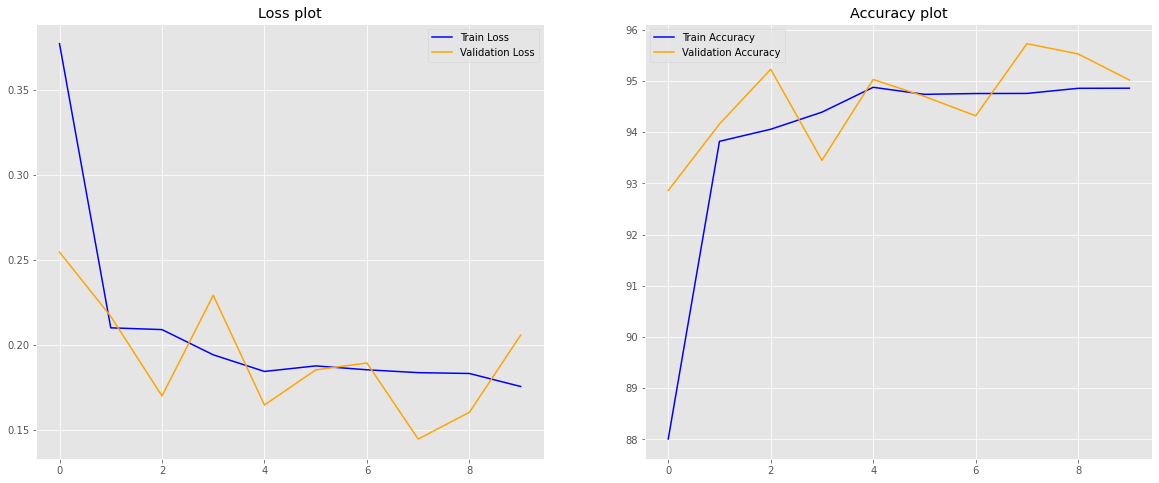

In [18]:
##############################################################
##          Plot metrics graph for different epochs         ##
##                        Your Code                         ##
##############################################################

fig = plt.figure(figsize=(20, 8))

fig.add_subplot(1, 2, 1)
plt.plot(train_losses, color = 'blue', label = 'Train Loss')
plt.plot(val_losses, color = 'orange', label = 'Validation Loss')
plt.title('Loss plot')
plt.legend(loc ='upper right')

fig.add_subplot(1, 2, 2)
plt.plot(train_accuracies, color = 'blue', label = 'Train Accuracy')
plt.plot(val_accuracies, color = 'orange', label = 'Validation Accuracy')
plt.title('Accuracy plot')
plt.legend(loc='upper left')

# Test Model (20 Points)

In [19]:
##################################################
##          Test your model on test-set         ##
##          and plot confusion matrix           ##
##################################################


def update_confusion_matrix(confusion, preds, labels):
    for i in range(len(labels)):
        if labels[i] == preds[i]:
            confusion[labels[i]][labels[i]] += 1
        else:
            confusion[labels[i]][preds[i]] += 1
            
    return confusion


test_data = datasets.MNIST(root='data/', download=True, transform=transformation, train=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

correct = 0
total = 0
total_loss = 0
confusion = torch.zeros((10, 10)).to(device)
model.eval()
with torch.no_grad(), tqdm(enumerate(test_loader), total = len(test_loader)) as pbar:
    for i, (images, labels) in pbar:
        images, labels = images.to(device), labels.to(device)
            
        output = model(images)
        loss = criterion(output, labels)
            
        _, preds = output.max(dim=1)
            
        correct += (preds == labels).sum().item()
        confusion = update_confusion_matrix(confusion, preds, labels)
        total_loss += loss.item()
        total += labels.size(0)
            
acc = (correct/total) * 100.0
tloss = total_loss/len(val_loader)
        
val_losses.append(tloss)
val_accuracies.append(acc)
print('validation epooch {}: acc={}, loss={}'.format(epoch, acc, tloss))

100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 94.73it/s]

validation epooch 9: acc=95.43, loss=0.04550991201596335


(-0.5, 9.5, 9.5, -0.5)

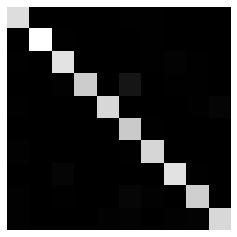

In [20]:
plt.matshow(confusion.cpu().numpy(), cmap = plt.cm.gray)
plt.ylabel('true')
plt.xlabel('predicted')
plt.axis('off')